# Compare QTLs with and without cell populations
- V03: Add analysis of interaction terms
- V02: compare top hit (the same variant in both analyses)


In [68]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_qtls")

In [69]:
invisible(suppressWarnings(file.link("/home/matteo/notebooks/cardips_cardiac_qtls/initialize_qtl_analyses.ipynb", "analysis/initialize_qtl_analyses.ipynb")))

source("analysis/cardiac_qtls_packages.R"      )
source("analysis/cardiac_qtls_input_files.R"   )
source("analysis/cardiac_qtls_functions.R"     )
source("analysis/cardiac_qtls_input_data.R"    )
source("analysis/cardiac_qtls_load_metadata.R" )


Loading packages...
Loading input files...
Loading functions...
Loading input data...
Loading metadata...


In [70]:
tissues         = c("eqtls_ipsc_cvpcs_only_bulk", "eqtls_ipsc_cvpcs_only_v01", "job101_mouse_ventricle_only_bulk", "job101_mouse_ventricle"  )
tissue2name     = data.frame(tissue = tissues, name = c("iPSC-CVPCs (bulk resolution)", "iPSC-CVPCs (cell populations)", "Adult heart (bulk resolution)", "Adult heart (cell populations)"), color = c("#84C01E", "#BCEE68", "#AC2A13", "#EE6A50"), y = c(4:1))
qtl_list        = lapply(tissues , function(x){read.table(paste("qtls/", x, "/analysis/egenes.", x, ".txt", sep = ""), header = TRUE)})
names(qtl_list) = tissues


In [71]:
lapply(qtl_list, function(x){nrow(x[x$egene == TRUE & x$type == "primary",])})

$eqtls_ipsc_cvpcs_only_bulk
[1] 8725

$eqtls_ipsc_cvpcs_only_v01
[1] 13440

$job101_mouse_ventricle_only_bulk
[1] 3521

$job101_mouse_ventricle
[1] 14666

In [72]:
qtl2egenes = function(qtl_list, tissue)
{
    x = qtl_list[[tissue]]
    return(data.frame(tissue = tissue, genes = nrow(x[x$type == "primary",]), egenes = nrow(x[x$egene == TRUE & x$type == "primary",])))
}

egenes = do.call("rbind", lapply(tissue2name$tissue, function(tissue){qtl2egenes(qtl_list, tissue)}))
egenes = merge(egenes, tissue2name)



In [73]:
egenes

tissue,genes,egenes,name,color,y
eqtls_ipsc_cvpcs_only_bulk,21921,8725,iPSC-CVPCs (bulk resolution),#84C01E,4
eqtls_ipsc_cvpcs_only_v01,21905,13440,iPSC-CVPCs (cell populations),#BCEE68,3
job101_mouse_ventricle,22480,14666,Adult heart (cell populations),#EE6A50,1
job101_mouse_ventricle_only_bulk,22553,3521,Adult heart (bulk resolution),#AC2A13,2


In [74]:
qtl2overlap = function(qtl_list, tissue1, tissue2)
{
    x1 = qtl_list[[tissue1]]
    x2 = qtl_list[[tissue2]]
    
    x1$overlap = FALSE
    x1[x1$gene_id %in% x2[x2$egene == TRUE, "gene_id"], "overlap"] = TRUE
    
    return(x1)
}

qtl_list2 = list(eqtls_ipsc_cvpcs_only_bulk       = qtl2overlap(qtl_list, "eqtls_ipsc_cvpcs_only_bulk"      , "eqtls_ipsc_cvpcs_only_bulk"      ),
                 eqtls_ipsc_cvpcs_only_v01        = qtl2overlap(qtl_list, "eqtls_ipsc_cvpcs_only_v01"       , "eqtls_ipsc_cvpcs_only_bulk"      ),
                 job101_mouse_ventricle_only_bulk = qtl2overlap(qtl_list, "job101_mouse_ventricle_only_bulk", "job101_mouse_ventricle_only_bulk"),
                 job101_mouse_ventricle           = qtl2overlap(qtl_list, "job101_mouse_ventricle"          , "job101_mouse_ventricle_only_bulk")
                )

In [75]:
str(qtl_list2)

List of 4
 $ eqtls_ipsc_cvpcs_only_bulk      :'data.frame':	21921 obs. of  24 variables:
  ..$ gene_id    : chr [1:21921] "ENSG00000000003.10" "ENSG00000000005.5" "ENSG00000000419.8" "ENSG00000000457.9" ...
  ..$ gene_name  : chr [1:21921] "TSPAN6" "TNMD" "DPM1" "SCYL3" ...
  ..$ gene_type  : chr [1:21921] "protein_coding" "protein_coding" "protein_coding" "protein_coding" ...
  ..$ start      : int [1:21921] 99883666 99839798 49551403 169818771 169631244 27938574 196621007 143815947 53362138 41040683 ...
  ..$ end        : int [1:21921] 99894988 99854882 49575092 169863408 169823221 27961788 196716634 143832827 53481768 41067715 ...
  ..$ strand     : chr [1:21921] "-" "+" "-" "-" ...
  ..$ gene_status: chr [1:21921] "KNOWN" "KNOWN" "KNOWN" "KNOWN" ...
  ..$ source     : chr [1:21921] "HAVANA" "HAVANA" "HAVANA" "HAVANA" ...
  ..$ level      : int [1:21921] 2 2 2 2 2 2 1 2 2 2 ...
  ..$ id         : chr [1:21921] "X_100546476_CGGAGCGCCGAGG_C" "CNV_X_100566186_100567597_HipSci" "Human_S

# Compare with GTEx: 
- how many tissues eGene?

In [76]:
gtex_folder                    = "/publicdata/gtex_v7"
gtex2col                       = read.table(paste(gtex_folder, "Color_scheme", sep = "/"), header = FALSE, col.names = c("tissue", "color"), comment.char = "")
gtex_samples                   = read.table(paste(gtex_folder, "eqtl_summary.txt", sep = "/"), header = TRUE, sep = "\t")
gtex_samples$uberon            = NULL
gtex_samples$sample_size_total = NULL
gtex_samples$tissue            = gsub("EBV", "EBV-", gsub("c1", "c-1", gsub("[ ]+", "_", gsub("-", "", gsub("\\(", "", gsub("\\)", "", gtex_samples$tissue_name))))))
gtex_samples                   = merge(gtex_samples, gtex2col)
gtex_samples$egenes            = as.numeric(gtex_samples$egenes)


In [77]:
qtls_by_tissue = function(tissue)
{
    infile = paste("/publicdata/gtex_v7/GTEx_Analysis_v7_eQTL/", tissue, ".v7.egenes.txt", sep = "")
    indata = fread(infile, sep = "\t", header = TRUE, data.table = FALSE)
    
    return(data.frame(gene_id = indata[indata$qval < 0.05, "gene_id"], tissue = tissue))
}

qtls_all   = do.call("rbind", lapply(gtex_samples$tissue, qtls_by_tissue))
qtls_table = as.data.frame.matrix(table(qtls_all), stringsAsFactors = FALSE)
colnames(qtls_table) = tolower(colnames(qtls_table))

In [78]:
count_tissues = function(tissue, x, qtls_table)
{
    this         = qtls_table[,grepl(tissue, colnames(qtls_table)) == FALSE]
    tomerge      = data.frame(gene_id = rownames(this), n = rowSums(this))
    out          = merge(x, tomerge)
    out$abs_beta = abs(out$beta)
    out$diff     = out$se / out$abs_beta
    
    return(out)
}

qtls2n        = lapply(names(qtl_list2), function(tissue){count_tissues(tissue, qtl_list2[[tissue]], qtls_table)})
names(qtls2n) = names(qtl_list2)

In [79]:
str(qtls2n)

List of 4
 $ eqtls_ipsc_cvpcs_only_bulk      :'data.frame':	20140 obs. of  27 variables:
  ..$ gene_id    : chr [1:20140] "ENSG00000000003.10" "ENSG00000000005.5" "ENSG00000000419.8" "ENSG00000000457.9" ...
  ..$ gene_name  : chr [1:20140] "TSPAN6" "TNMD" "DPM1" "SCYL3" ...
  ..$ gene_type  : chr [1:20140] "protein_coding" "protein_coding" "protein_coding" "protein_coding" ...
  ..$ start      : int [1:20140] 99883666 99839798 49551403 169818771 169631244 27938574 196621007 143815947 53362138 41040683 ...
  ..$ end        : int [1:20140] 99894988 99854882 49575092 169863408 169823221 27961788 196716634 143832827 53481768 41067715 ...
  ..$ strand     : chr [1:20140] "-" "+" "-" "-" ...
  ..$ gene_status: chr [1:20140] "KNOWN" "KNOWN" "KNOWN" "KNOWN" ...
  ..$ source     : chr [1:20140] "HAVANA" "HAVANA" "HAVANA" "HAVANA" ...
  ..$ level      : int [1:20140] 2 2 2 2 2 2 1 2 2 2 ...
  ..$ id         : chr [1:20140] "X_100546476_CGGAGCGCCGAGG_C" "CNV_X_100566186_100567597_HipSci" "Human_S

tissue,cells,original
eqtls_ipsc_cvpcs_only_v01,13.89781,15.08295
job101_mouse_ventricle,13.29543,24.50798


tissue,cells,original
eqtls_ipsc_cvpcs_only_v01,0.8241764,1.035474
job101_mouse_ventricle,0.9166640,1.040064


tissue,cells,original
eqtls_ipsc_cvpcs_only_v01,0.2531404,0.2647396
job101_mouse_ventricle,0.2521952,0.2507945


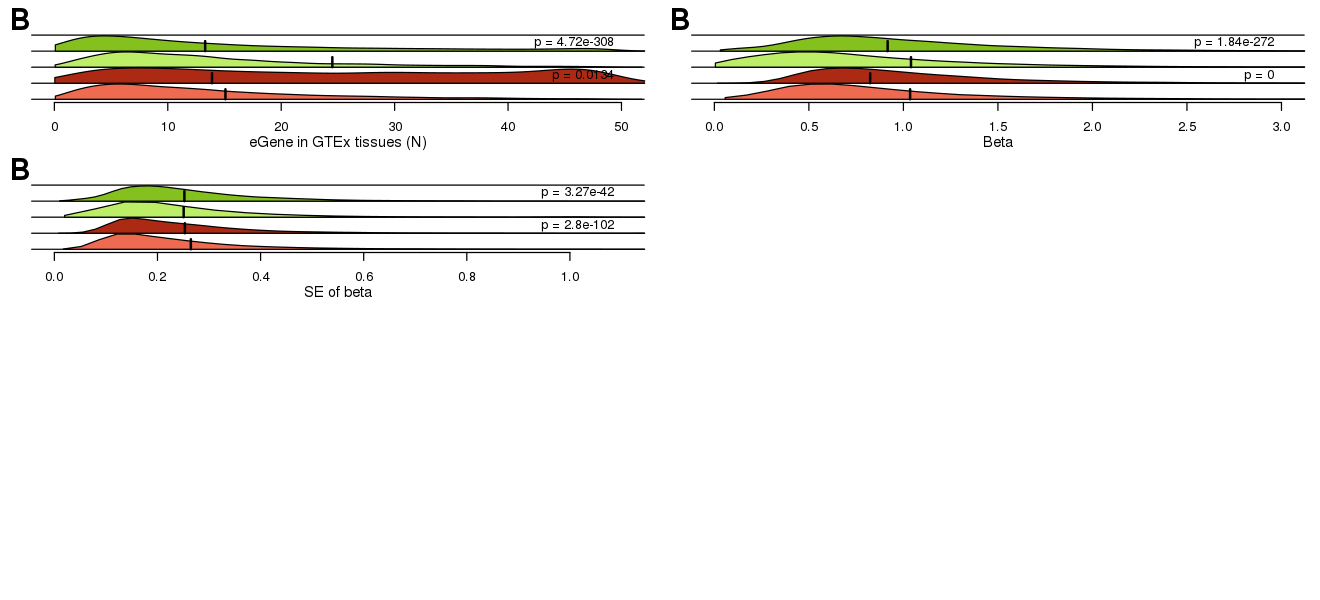

In [80]:
density_lines = function(x)
{
    if (length(x) > 0)
    {
        dens = density(x)
        dens = data.frame(x = dens$x, y = dens$y)
        dens = dens[dens$x >= 0,]
        
        dens = rbind(dens, data.frame(x = c(max(dens$x), min(dens$x)), y = c(0,0)))
        #dens = rbind(dens, data.frame(x = rev(xlim), y = c(0,0)))

        return(dens)
    }
}

polygon_density = function(dens, color, y0, yscale = 0.95)
{
    if (nrow(dens) > 0)
    {
        polygon(dens$x, (dens$y / max(dens$y) * yscale) + y0, col = color)
    }
}


plot_densities_gtex = function(qtls2n, tissue2name, column, filter, xmax, main, panel)
{
    if (filter == TRUE ){qtl2tissues_true  = lapply(qtls2n, function(x){x[x$egene == TRUE & x$overlap == TRUE , column]})}
    if (filter == TRUE ){qtl2tissues_false = lapply(qtls2n, function(x){x[x$egene == TRUE & x$overlap == FALSE, column]})}
    if (filter == FALSE){qtl2tissues_true  = lapply(qtls2n, function(x){x[, column]})}
    if (filter == FALSE){qtl2tissues_false = lapply(qtls2n, function(x){x[, column]})}
    names(qtl2tissues_true ) = names(qtl2tissues_true )
    names(qtl2tissues_false) = names(qtl2tissues_false)
    

    dens_list_true  = lapply(qtl2tissues_true , density_lines)
    dens_list_false = lapply(qtl2tissues_false, density_lines)

    #tissue2name = tissue2name[order(tissue2name$y, decreasing = TRUE),]
    
    plot(1,1, type = "n", xlim = c(0, xmax), ylim = c(1,6), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    mtext(text = main, side = 1, line = 2, cex = 0.75)
    abline(h = 1:5)

    polygon_density(dens_list_true [[tissue2name[1, "tissue"]]], tissue2name[1, "color"], tissue2name[1, "y"])
    polygon_density(dens_list_false[[tissue2name[2, "tissue"]]], tissue2name[2, "color"], tissue2name[2, "y"])
    polygon_density(dens_list_true [[tissue2name[3, "tissue"]]], tissue2name[3, "color"], tissue2name[3, "y"])
    polygon_density(dens_list_false[[tissue2name[4, "tissue"]]], tissue2name[4, "color"], tissue2name[4, "y"])
    
    segments(x0 = c(mean(qtl2tissues_true [[tissue2name[1, "tissue"]]]), 
                    mean(qtl2tissues_false[[tissue2name[2, "tissue"]]]), 
                    mean(qtl2tissues_true [[tissue2name[3, "tissue"]]]), 
                    mean(qtl2tissues_false[[tissue2name[4, "tissue"]]])), 
             y0 = 1:4, y1 = 2:5, col = "#000000", lty = "dashed", lwd = 2)
    

    #text(x = rep(xmax/2, 5), y = (5:1)+0.5, labels = tissue2name$name, pos = 3)
    mtext(text = panel, side = 2, line = 0, cex = 1.5 , at = 6, las = 1, font = 2)

    text(xmax, 2.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[[tissue2name[2, "tissue"]]], qtl2tissues_true[[tissue2name[1, "tissue"]]])$p.value, digits = 3), sep = " = "), pos = 2)
    text(xmax, 4.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[[tissue2name[4, "tissue"]]], qtl2tissues_true[[tissue2name[3, "tissue"]]])$p.value, digits = 3), sep = " = "), pos = 2)
    
    return(data.frame(tissue   = c(tissue2name[c(2,4), "tissue"]), 
                      cells    = c(mean(qtl2tissues_false[[tissue2name[2, "tissue"]]], na.rm = TRUE), mean(qtl2tissues_false[[tissue2name[4, "tissue"]]], na.rm = TRUE)),
                      original = c(mean(qtl2tissues_true [[tissue2name[1, "tissue"]]], na.rm = TRUE), mean(qtl2tissues_true [[tissue2name[3, "tissue"]]], na.rm = TRUE))
                     ))
}

par(mfrow = c(4,2), mar = c(3,2,1,1))
plot_densities_gtex(qtls2n, tissue2name, "n"       , filter = TRUE , 50  , main = "eGene in GTEx tissues (N)", "B")
plot_densities_gtex(qtls2n, tissue2name, "abs_beta", filter = FALSE,  3  , main = "Beta"                     , "B")
plot_densities_gtex(qtls2n, tissue2name, "se"      , filter = FALSE,  1.1, main = "SE of beta"               , "B")



In [82]:
barplot_egenes = function(tissues, qtl_list, tissue2name)
{
    
    plot(1,1, type = "n", xlab = "", ylab = "", xlim = range(as.numeric(unlist(lapply(qtl_list, function(x){range(x$exp)})))), ylim = range(as.numeric(unlist(lapply(qtl_list, function(x){range(x$logp)})))))
    
    invisible(lapply(tissues, function(tissue){points(qtl_list[[tissue]][,"exp"], qtl_list[[tissue]][,"logp"], col = tissue2name[tissue2name$tissue == tissue, "color"], pch = 16)}))
}

#barplot_egenes = (tissues, qtl_list, tissue2name)


#run_qqplot(tissues, qtl_list, tissue2name)


ERROR: Error in parse(text = x, srcfile = src): <text>:9:26: unexpected ','
8: 
9: barplot_egenes = (tissues,
                            ^


# Scatterplot QTLs

0.97372423252411
0.953257789905667


tissue,tissue1,tissue2,genes,ns,only1,only2,both
iPSC-CVPCs,eqtls_ipsc_cvpcs_only_bulk,eqtls_ipsc_cvpcs_only_v01,16432,5488,12,3997,6935
Adult heart,job101_mouse_ventricle_only_bulk,job101_mouse_ventricle,17100,5862,0,8087,3151


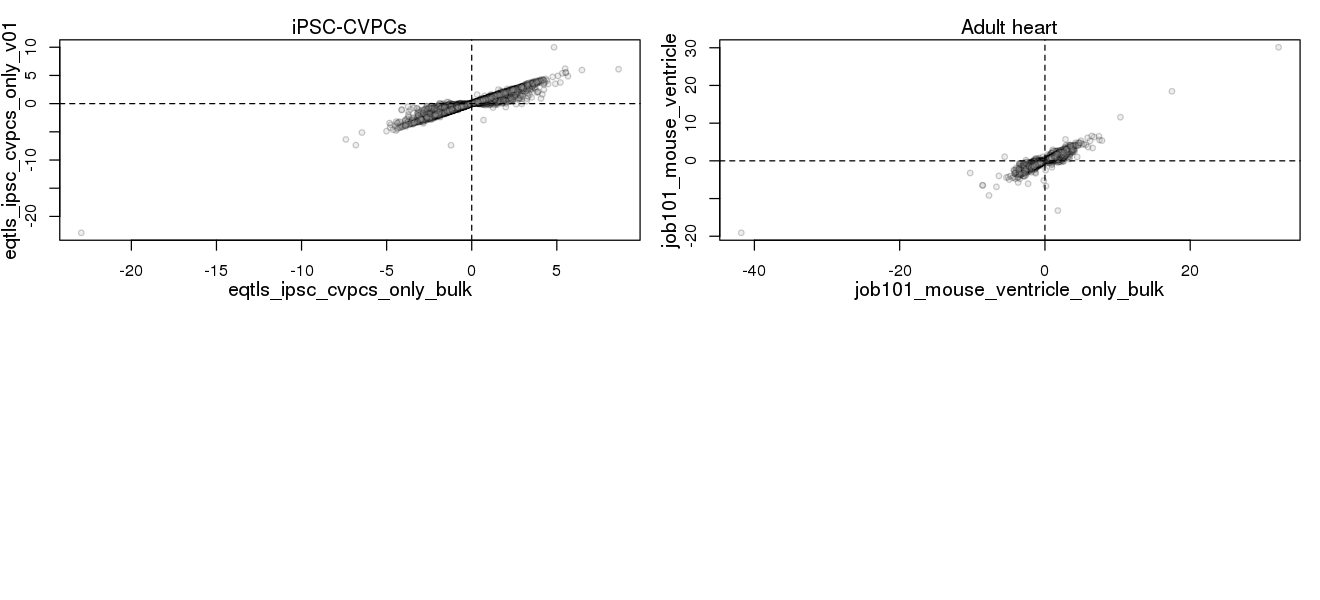

In [83]:
compare_qtls = function(tissue1, tissue2, tissue)
{
    qtls1 = read.table(paste("qtls/", tissue1, "/analysis/egenes.", tissue1, ".txt", sep = ""), header = TRUE)
    qtls2 = read.table(paste("qtls/", tissue2, "/analysis/egenes.", tissue2, ".txt", sep = ""), header = TRUE)
    qtls1$gene_var = paste(qtls1$gene_id, qtls1$id)
    qtls2$gene_var = paste(qtls2$gene_id, qtls2$id)
    
    qtls  = merge(qtls1[,c("gene_var", "egene", "beta", "se", "bonferroni")], qtls2[,c("gene_var", "egene", "beta", "se", "bonferroni")], by = "gene_var", suffixes = 1:2)
    
    qtls$color = "#aaaaaa"
    qtls[qtls$egene1 == TRUE  & qtls$egene2 == TRUE , "color"] = "#ff0000"
    qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE, "color"] = "#ff00ff"
    qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE , "color"] = "#00ffff"
    qtls = rbind(qtls[qtls$egene1 == FALSE & qtls$egene2 == FALSE,],
                 qtls[qtls$egene1 == TRUE  & qtls$egene2 == TRUE ,],
                 qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE ,],
                 qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE,]
                )
    
    message(cor(qtls$beta1, qtls$beta2))
    
    plot(qtls$beta1, qtls$beta2, bg = "#aaaaaa33", col = "#00000033", pch = 21, cex = 0.75, xlab = "", ylab = "", main = "")
    #smoothScatter(qtls$beta1, qtls$beta2, bg = qtls$color, xlab = "", ylab = "", main = "", nrpoints = 0)
    #points(qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE , "beta1"], qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE , "beta2"], bg = "#00ffff", pch = 21, cex = 0.75)
    #points(qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE, "beta1"], qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE, "beta2"], bg = "#ff00ff", pch = 21, cex = 0.75)
    
    abline(h = 0, lty = "dashed")
    abline(v = 0, lty = "dashed")
    mtext(text = tissue1, side = 1, line = 2  )
    mtext(text = tissue2, side = 2, line = 2  )
    mtext(text = tissue , side = 3, line = 0.1)
    
    #text(x = rep(min(qtls$beta1),5), y = (0:(-4)) + max(qtls$beta2), cex = 0.75, pos = 4,
    #     labels = c(paste("Genes", nrow(qtls1), sep = ": "),
    #                paste("Genes with the same top hit", nrow(qtls), sep = ": "),
    #                paste("eGenes", tissue1, "only:"   , nrow(qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE,]), sep = " "),
    #                paste("eGenes", tissue2, "only:"   , nrow(qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE ,]), sep = " "),
    #                paste("eGenes both tissues:"       , nrow(qtls[qtls$egene1 == TRUE  & qtls$egene2 == TRUE ,]), sep = " ")))
    #
    #points(x = rep(min(qtls$beta1),3), y = (-2:(-4)) + max(qtls$beta2), pch = 21, bg = c("#ff00ff", "#00ffff", "#ff0000"))
    
    #legend("bottomright", pch = 21, pt.bg = c("#aaaaaa", "#ff00ff", "#00ffff", "#ff0000"),
    #       legend = c("Not significant", tissue1, tissue2, "Both"))
    
    write.table(qtls, file = paste("qtls", tissue1, tissue2, "txt", sep = "."), quote = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE)
    
    return(data.frame(tissue  = tissue,
                      tissue1 = tissue1, 
                      tissue2 = tissue2, 
                      genes   = nrow(qtls), 
                      ns      = nrow(qtls[qtls$egene1 == FALSE & qtls$egene2 == FALSE,]),
                      only1   = nrow(qtls[qtls$egene1 == TRUE  & qtls$egene2 == FALSE,]),
                      only2   = nrow(qtls[qtls$egene1 == FALSE & qtls$egene2 == TRUE ,]),
                      both    = nrow(qtls[qtls$egene1 == TRUE  & qtls$egene2 == TRUE ,])
                     ))
    
    #return(list(#qtls1      = qtls1, 
    #            #qtls2      = qtls2,
    #            ttest_beta = t.test(abs(qtls$beta2), abs(qtls$beta1), paired = TRUE),
    #            ttest_se   = t.test(qtls$se2  , qtls$se1  , paired = TRUE)))
}

par(mfrow = c(2,2), mar = c(3,3,2,1))

out1 = compare_qtls(tissue2name[1, "tissue"], tissue2name[2, "tissue"], "iPSC-CVPCs" )
out2 = compare_qtls(tissue2name[3, "tissue"], tissue2name[4, "tissue"], "Adult heart")

qtl2plot = rbind(out1, out2)

qtl2plot

In [84]:
qtl2plot_data = function(tissue)
{
    qtls = read.table(paste("qtls/", tissue, "/analysis/egenes."     , tissue, ".txt", sep = ""), header = TRUE)
    
    out = data.frame(tissue = tissue, egenes = nrow(qtls[qtls$egene == TRUE,]), ns = nrow(qtls[qtls$egene == FALSE,]))
    
    return(out)
}

qtl2plot = do.call("rbind", lapply(tissue2name$tissue, qtl2plot_data))


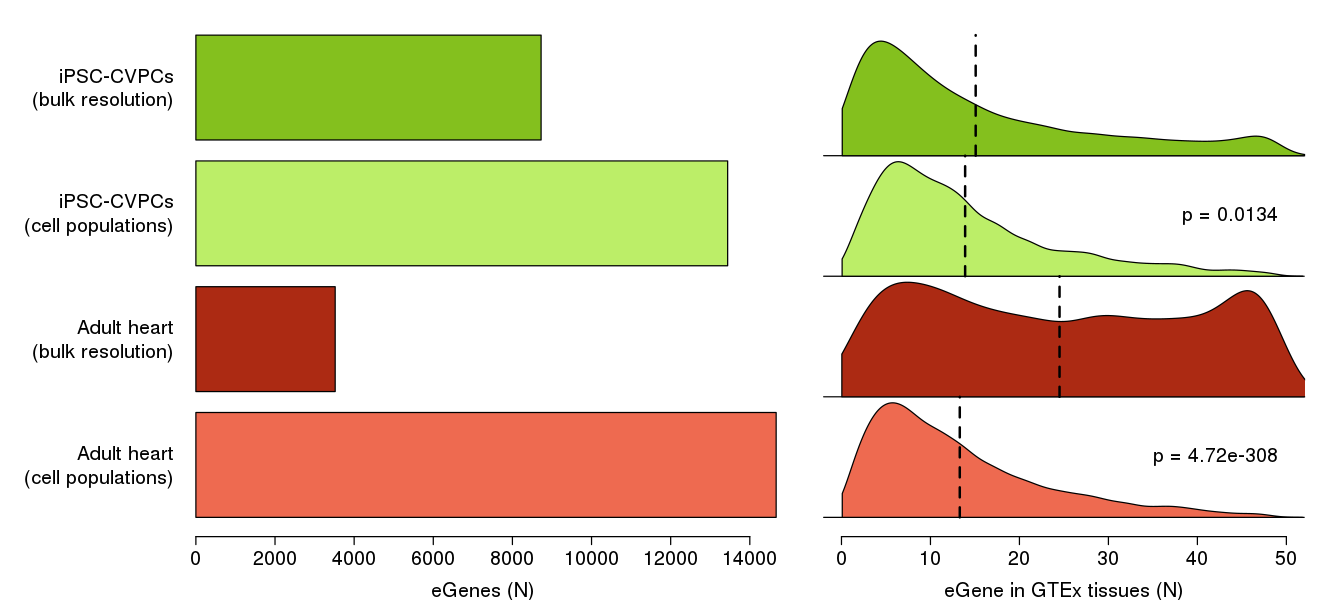

In [87]:
plot_densities_gtex = function(qtls2n, tissue2name, column, filter, xmax, main, panel)
{
    if (filter == TRUE ){qtl2tissues_true  = lapply(qtls2n, function(x){x[x$egene == TRUE & x$overlap == TRUE , column]})}
    if (filter == TRUE ){qtl2tissues_false = lapply(qtls2n, function(x){x[x$egene == TRUE & x$overlap == FALSE, column]})}
    if (filter == FALSE){qtl2tissues_true  = lapply(qtls2n, function(x){x[, column]})}
    if (filter == FALSE){qtl2tissues_false = lapply(qtls2n, function(x){x[, column]})}
    names(qtl2tissues_true ) = names(qtl2tissues_true )
    names(qtl2tissues_false) = names(qtl2tissues_false)
    

    dens_list_true  = lapply(qtl2tissues_true , density_lines)
    dens_list_false = lapply(qtl2tissues_false, density_lines)

    #tissue2name = tissue2name[order(tissue2name$y, decreasing = TRUE),]
    
    plot(1,1, type = "n", xlim = c(0, xmax), ylim = c(1,5), xlab = "", ylab = "", axes = FALSE)
    axis(1, cex.axis = 1.5)
    mtext(text = main, side = 1, line = 3, cex = 1)
    abline(h = 1:4)

    polygon_density(dens_list_true [[tissue2name[1, "tissue"]]], tissue2name[1, "color"], tissue2name[1, "y"])
    polygon_density(dens_list_false[[tissue2name[2, "tissue"]]], tissue2name[2, "color"], tissue2name[2, "y"])
    polygon_density(dens_list_true [[tissue2name[3, "tissue"]]], tissue2name[3, "color"], tissue2name[3, "y"])
    polygon_density(dens_list_false[[tissue2name[4, "tissue"]]], tissue2name[4, "color"], tissue2name[4, "y"])
    
    segments(x0 = c(mean(qtl2tissues_true [[tissue2name[1, "tissue"]]]), 
                    mean(qtl2tissues_false[[tissue2name[2, "tissue"]]]), 
                    mean(qtl2tissues_true [[tissue2name[3, "tissue"]]]), 
                    mean(qtl2tissues_false[[tissue2name[4, "tissue"]]])), 
             y0 = 4:1, y1 = 5:2, col = "#000000", lty = "dashed", lwd = 2)
    

    #text(x = rep(xmax/2, 5), y = (5:1)+0.5, labels = tissue2name$name, pos = 3)
    mtext(text = panel, side = 2, line = 0, cex = 1.5 , at = 6, las = 1, font = 2)

    text(xmax, 3.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[[tissue2name[2, "tissue"]]], qtl2tissues_true[[tissue2name[1, "tissue"]]])$p.value, digits = 3), sep = " = "), pos = 2, cex = 1.5)
    text(xmax, 1.5, labels = paste("p", signif(wilcox.test(qtl2tissues_false[[tissue2name[4, "tissue"]]], qtl2tissues_true[[tissue2name[3, "tissue"]]])$p.value, digits = 3), sep = " = "), pos = 2, cex = 1.5)
    
    return(data.frame(tissue   = c(tissue2name[c(2,4), "tissue"]), 
                      cells    = c(mean(qtl2tissues_false[[tissue2name[2, "tissue"]]], na.rm = TRUE), mean(qtl2tissues_false[[tissue2name[4, "tissue"]]], na.rm = TRUE)),
                      original = c(mean(qtl2tissues_true [[tissue2name[1, "tissue"]]], na.rm = TRUE), mean(qtl2tissues_true [[tissue2name[3, "tissue"]]], na.rm = TRUE))
                     ))
}

barplot_egenes = function(panel)
{
    egenes = egenes[order(egenes$y, decreasing = FALSE),]
    barplot(egenes$egenes, names.arg = gsub(" \\(", "\n(", egenes$name), horiz = TRUE, las = 1, col = egenes$color, cex.names = 1.5, cex.axis = 1.5)
    mtext(text = panel, side = 2, line = 6.5, cex = 1.5 , at = 6, las = 1, font = 2)
    mtext(text = "eGenes (N)", side = 1, line = 3, cex = 1)
}

#options(repr.plot.width=7, repr.plot.height=11)
#layout(cbind(c(8,8,10,10,1:4), c(8,8, 10,10,1:4), c(8,8,10,10,5,5,6,7), c(9,9,11,11,5,5,6,7), c(9,9,11,11,5,5,6,7), c(9,9,11,11,5,5,6,7)))

options(repr.plot.width=11, repr.plot.height=5)
layout(rbind(c(1,1,1,2,2)))

par(mar = c(4,12,1,1))
barplot_egenes("")

par(mar = c(4,2,1,1))
outb1 = plot_densities_gtex(qtls2n, tissue2name, "n"       , filter = TRUE , 50  , main = "eGene in GTEx tissues (N)", "")
#outb2 = plot_densities_gtex(qtls2n, tissue2name, "abs_beta", filter = FALSE,  3  , main = "Beta"                     , "C")
#outb3 = plot_densities_gtex(qtls2n, tissue2name, "se"      , filter = FALSE,  1.1, main = "SE of beta"               , "D")

distr = rbind(outb1, outb2, outb3)


In [ ]:
str(egenes)

In [ ]:
out       = rbind(out1, out2, out3)
out$tot   = rowSums(out[,c("unique", "shared")])
out$ratio = out$unique / out$tot

out_dt = data.table(out)

totest = data.frame(out_dt[ , .(sum = sum(tot), mean = mean(tot), mean_ratio = mean(ratio), unique = sum(unique), shared = sum(shared), .N), by = .(tissue)] )
totest = merge(totest, egenes[,c("genes", "egenes", "name")], by.x = "tissue", by.y = "name")
totest$not = totest$egenes - totest$sum
totest$original = c(1369, 1369, 9232)

totest$not_unique   = totest$egenes   - totest$unique
totest$not_original = totest$original - totest$shared

fisher.test(as.matrix(totest[totest$tissue %in% c("Liver (human cell populations)", "Liver (mouse cell populations)"), c("sum", "not")]))
fisher.test(as.matrix(totest[totest$tissue %in% c("Liver (human cell populations)", "Liver (mouse cell populations)"), c("sum", "not")]))$p.value

fisher.test(matrix(as.numeric(totest[totest$tissue == "Liver (human cell populations)", c("unique", "not_unique", "shared", "not_original")]), nrow = 2))
fisher.test(matrix(as.numeric(totest[totest$tissue == "Liver (mouse cell populations)", c("unique", "not_unique", "shared", "not_original")]), nrow = 2))
fisher.test(matrix(as.numeric(totest[totest$tissue == "Skin (mouse cell populations)" , c("unique", "not_unique", "shared", "not_original")]), nrow = 2))


sum(totest$sum)

totest$unique/totest$egenes
totest$shared/totest$original


totest

In [ ]:
as.numeric(totest[totest$tissue == "Liver (human cell populations)", c("unique", "not_unique", "shared", "not_original")])

# OLD

In [ ]:
toqq = function(x)
{
    x$logp = -log10(x$bonferroni)
    x = x[order(x$logp),]
    x$exp = -log10((nrow(x):1) / nrow(x))
    
    return(x)
}

tissues         = c("liver_original", "liver_cells", "liver2_cells", "skin_original", "skin_cells"  )
qtl_list        = lapply(tissues , function(x){read.table(paste("qtls/", x, "/analysis/egenes.", x, ".txt", sep = ""), header = TRUE)})
qtl_list        = lapply(qtl_list, toqq)
names(qtl_list) = tissues
tissue2name     = data.frame(tissue = tissues, name = c("Liver (original)", "Liver (mouse cell populations)", "Liver (human cell populations)", "Skin (original)", "Skin (mouse cell populations)" ), color = c("#FF7256", "#CD3700", "#800000", "#87CEFA", "#000080"))

In [ ]:
run_qqplot = function(tissues, qtl_list, tissue2name)
{
    plot(1,1, type = "n", xlab = "", ylab = "", xlim = range(as.numeric(unlist(lapply(qtl_list, function(x){range(x$exp)})))), ylim = range(as.numeric(unlist(lapply(qtl_list, function(x){range(x$logp)})))))
    
    invisible(lapply(tissues, function(tissue){points(qtl_list[[tissue]][,"exp"], qtl_list[[tissue]][,"logp"], col = tissue2name[tissue2name$tissue == tissue, "color"], pch = 16)}))
}

run_qqplot(tissues, qtl_list, tissue2name)
